In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Functions

In [159]:
def plot_graph(df, x_col = "Date", y_col = "Close", title = "S&P 500",
                        xlabel = 'Year', ylabel = 'Close value', start = "", end = ""):
    plt.figure(figsize=(12, 6))
    plt.plot(df[x_col], df[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.show()
    return df

def plot_diff_series(df, x_col = "Date", y_col = "Log_Close", periods=252, xlabel= "Year", ylabel = 'Close value change',
                    title = "Differentiated Series Yearly"):
    df_diff = df.copy()
    df_diff = df_diff.set_index(x_col)
    df_diff=df_diff.diff(periods=periods)
    df_diff=df_diff.dropna() 

    plt.figure(figsize=(12, 6))
    plt.plot(df_diff.index, df_diff[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    return df_diff

def decompose_time_series(df, y_col = "Log_Close", period = 252):
    decomposition = seasonal_decompose(df[y_col], model='additive', period=period)

    plt.figure(figsize=(14, 10))

    plt.subplot(411)
    plt.plot(df[y_col], label='Original')
    plt.legend(loc='upper left')
    plt.title('Original Series')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend(loc='upper left')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()
    return decomposition

# Data loading

In [92]:
sp500 = pd.read_csv("SPY1950.csv")
sp500["Date"] = pd.to_datetime(sp500["Date"], format = "%d/%m/%Y")

In [93]:
sp500.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


# Plotting the data

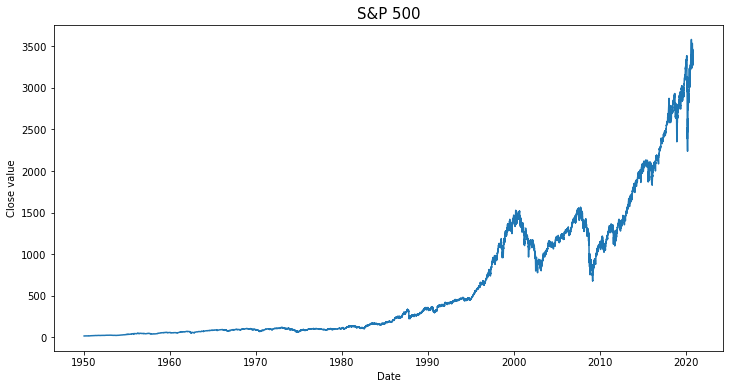

In [94]:
plot_graph(sp500);

this graph is rather exponential, lets take a look at the Log Close value

In [97]:
sp500["Log_Close"] = np.log(sp500["Close"])

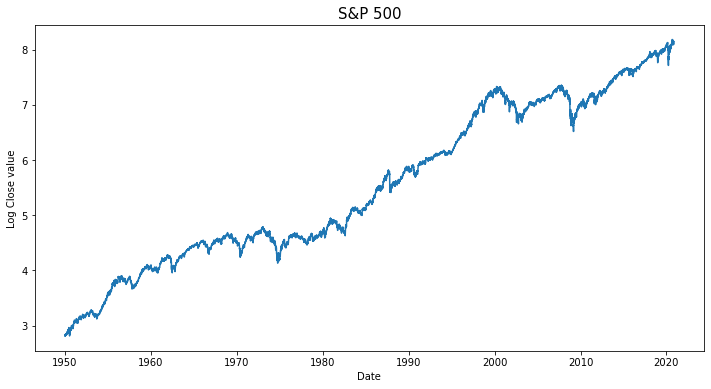

In [100]:
plot_graph(sp500, y_col= "Log_Close", ylabel = "Log Close value");

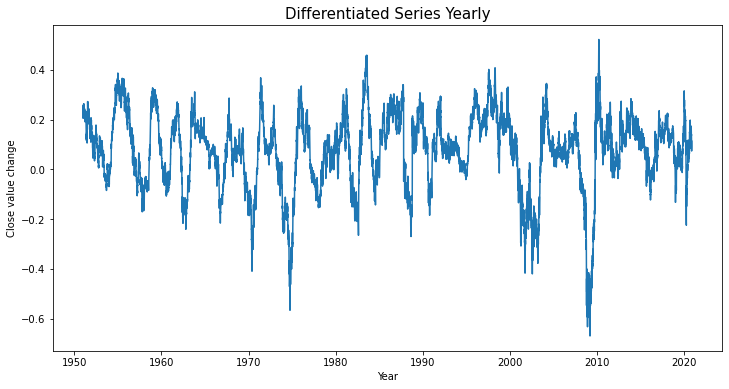

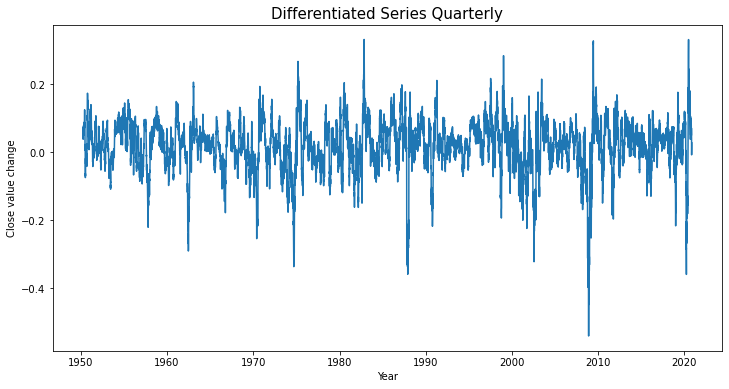

In [149]:
sp500_diff_Y = plot_diff_series(sp500)
sp500_diff_Q = plot_diff_series(sp500, periods=252/4, title = "Differentiated Series Quarterly")

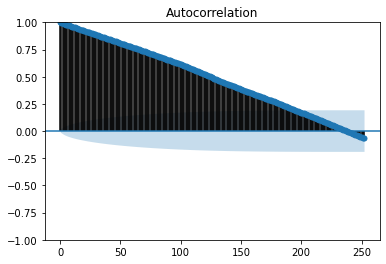

In [148]:
tsaplots.plot_acf(sp500_diff_Y["Log_Close"], lags=252);

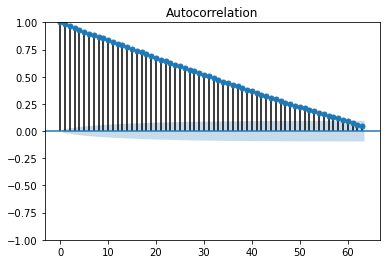

In [142]:
tsaplots.plot_acf(sp500_diff_Q["Log_Close"], lags=252/4);

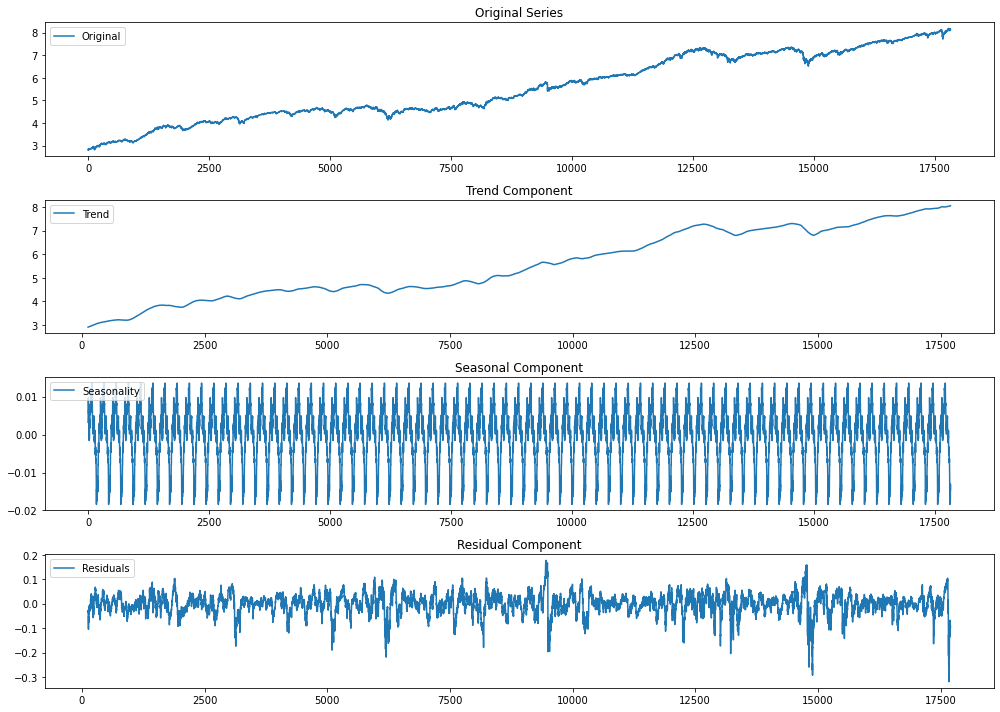

0        0.003223
1        0.004910
2        0.005074
3        0.005118
4        0.006089
           ...   
17822   -0.017519
17823   -0.016754
17824   -0.013212
17825   -0.013075
17826   -0.014552
Name: seasonal, Length: 17827, dtype: float64

In [160]:
decompose_time_series(sp500, y_col = "Log_Close", period = 252)

18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] done processing


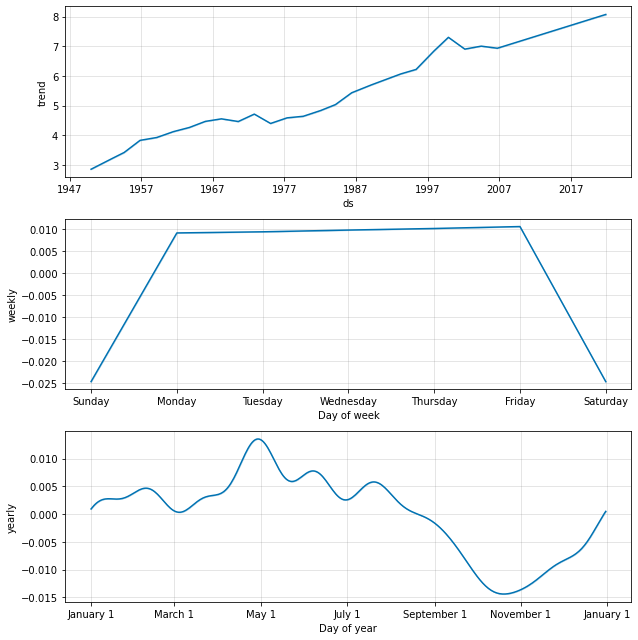

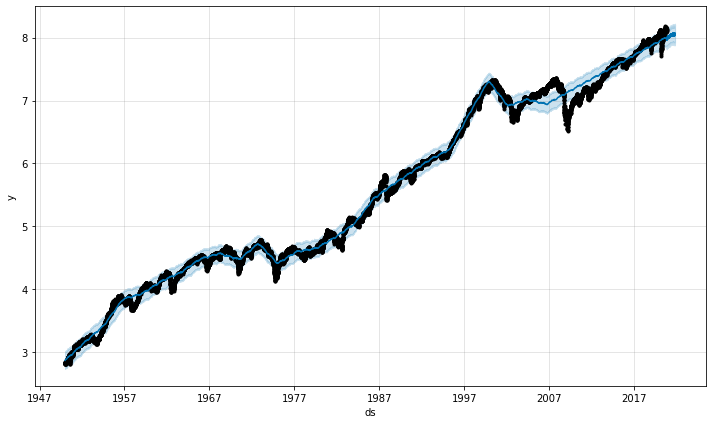

In [151]:
sp500_prophet = sp500.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
m = Prophet()
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);